In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrices
import statsmodels.api as sm
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

# Import data from math and from portuguese students
math_df = pd.read_csv('data/student/student-mat.csv', sep=';')
port_df = pd.read_csv('data/student/student-por.csv', sep=';')

In [2]:
math_df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [3]:
port_df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [4]:
# Get list of column/feature names for each
m_cols = math_df.columns
p_cols = port_df.columns

# Check for shape of df
print(math_df.shape)
# ---> 395 observations, 33 features
print(port_df.shape)
# ---> 649 observations, 33 features

# Check if columns in each are identical
print((m_cols == p_cols).all())

(395, 33)
(649, 33)
True


In [5]:
# Make list of binary features, based on feature descriptions
binary_vars = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
categorical_vars = ['Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']
appx_cont_vars = ['age', 'absences', 'G1', 'G2', 'G3']

In [6]:
# Function for getting a datatype subset df for each of my main dfs (math and port)
def make_dtype_dfs(df, binary_vars, categorical_vars, appx_cont_vars):
    b_df = df[binary_vars]
    cat_df = df[categorical_vars]
    cont_df = df[appx_cont_vars]
    return b_df, cat_df, cont_df

In [7]:
# Call like this:
m_bin_df, m_cat_df, m_cont_df = make_dtype_dfs(math_df, binary_vars, categorical_vars, appx_cont_vars)
p_bin_df, p_cat_df, p_cont_df = make_dtype_dfs(port_df, binary_vars, categorical_vars, appx_cont_vars)

In [8]:
m_bin_df.head()

,school,sex,address,famsize,Pstatus,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,GP,F,U,GT3,A,yes,no,no,no,yes,yes,no,no
1,GP,F,U,GT3,T,no,yes,no,no,no,yes,yes,no
2,GP,F,U,LE3,T,yes,no,yes,no,yes,yes,yes,no
3,GP,F,U,GT3,T,no,yes,yes,yes,yes,yes,yes,yes
4,GP,F,U,GT3,T,no,yes,yes,no,yes,yes,no,no


In [9]:
p_bin_df.head()

,school,sex,address,famsize,Pstatus,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,GP,F,U,GT3,A,yes,no,no,no,yes,yes,no,no
1,GP,F,U,GT3,T,no,yes,no,no,no,yes,yes,no
2,GP,F,U,LE3,T,yes,no,no,no,yes,yes,yes,no
3,GP,F,U,GT3,T,no,yes,no,yes,yes,yes,yes,yes
4,GP,F,U,GT3,T,no,yes,no,no,yes,yes,no,no


In [10]:
print(m_bin_df.shape, m_cat_df.shape, m_cont_df.shape)
print(p_bin_df.shape, p_cat_df.shape, p_cont_df.shape)

(395, 13) (395, 15) (395, 5)
(649, 13) (649, 15) (649, 5)


In [11]:
#Making function so that I can do this easily for both data sets
def convert_dummies(df, binary_vars):
    encoding_dict = dict()
    for col_name in binary_vars:
        new_col_name = col_name + '_d'
        # Make dictionary for individual col values
        col_dict = dict()
        # Grab unique values for given column
        unique_vals = df[col_name].unique()
        # Sort 'em
        unique_vals.sort()
        # If the first (of two) values is in this list is one of these...
        if unique_vals[0] in ['no', 'F', 'R']:
            # Then we'll encode the second value to equal 1 (first is baseline)
            df[new_col_name] = np.where(df[col_name] == unique_vals[1], 1, 0)
            # Add this info to individual column's disctionary
            col_dict[unique_vals[0]] = 0
            col_dict[unique_vals[1]] = 1
        # Do opposite (switch 1 and 0) for columns with other values
        else:
            df[new_col_name] = np.where(df[col_name] == unique_vals[0], 1, 0)
            col_dict[unique_vals[0]] = 1
            col_dict[unique_vals[1]] = 0
        # Add the column name and its encoding dictionary to the larger dictionary, so we can keep track of baseline values
        encoding_dict[col_name] = col_dict
    df.drop(columns=binary_vars, axis=1, inplace=True)
    return df, encoding_dict

In [12]:
# Use function to get new encoded dummy dfs and encoding dictionaries
m_bin_df, m_encoding_dict = convert_dummies(m_bin_df, binary_vars)
p_bin_df, p_encoding_dict = convert_dummies(p_bin_df, binary_vars)

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable

In [13]:
m_bin_df.head()

,school_d,sex_d,address_d,famsize_d,Pstatus_d,schoolsup_d,famsup_d,paid_d,activities_d,nursery_d,higher_d,internet_d,romantic_d
0,1,0,1,1,1,1,0,0,0,1,1,0,0
1,1,0,1,1,0,0,1,0,0,0,1,1,0
2,1,0,1,0,0,1,0,1,0,1,1,1,0
3,1,0,1,1,0,0,1,1,1,1,1,1,1
4,1,0,1,1,0,0,1,1,0,1,1,0,0


In [14]:
p_bin_df.head()

,school_d,sex_d,address_d,famsize_d,Pstatus_d,schoolsup_d,famsup_d,paid_d,activities_d,nursery_d,higher_d,internet_d,romantic_d
0,1,0,1,1,1,1,0,0,0,1,1,0,0
1,1,0,1,1,0,0,1,0,0,0,1,1,0
2,1,0,1,0,0,1,0,0,0,1,1,1,0
3,1,0,1,1,0,0,1,0,1,1,1,1,1
4,1,0,1,1,0,0,1,0,0,1,1,0,0


In [15]:
print(m_bin_df.shape, p_bin_df.shape)

(395, 13) (649, 13)


In [16]:
# Remove _d in column names... 
cols = m_bin_df.columns
cols = [col[:-2] for col in cols] 
m_bin_df.columns = cols
p_bin_df.columns = cols

In [17]:
print(m_bin_df.columns)
print(p_bin_df.columns)

Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup',
       'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic'],
      dtype='object')
Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup',
       'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic'],
      dtype='object')


In [18]:
m_bin_df.head()

,school,sex,address,famsize,Pstatus,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,1,0,1,1,1,1,0,0,0,1,1,0,0
1,1,0,1,1,0,0,1,0,0,0,1,1,0
2,1,0,1,0,0,1,0,1,0,1,1,1,0
3,1,0,1,1,0,0,1,1,1,1,1,1,1
4,1,0,1,1,0,0,1,1,0,1,1,0,0


In [19]:
p_bin_df.head()

,school,sex,address,famsize,Pstatus,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,1,0,1,1,1,1,0,0,0,1,1,0,0
1,1,0,1,1,0,0,1,0,0,0,1,1,0
2,1,0,1,0,0,1,0,0,0,1,1,1,0
3,1,0,1,1,0,0,1,0,1,1,1,1,1
4,1,0,1,1,0,0,1,0,0,1,1,0,0


In [20]:
# Print resulting encoding dictionary to make sure it's correctly specified
print(m_encoding_dict)
print(p_encoding_dict)
print(m_encoding_dict == p_encoding_dict)

{'school': {'GP': 1, 'MS': 0}, 'sex': {'F': 0, 'M': 1}, 'address': {'R': 0, 'U': 1}, 'famsize': {'GT3': 1, 'LE3': 0}, 'Pstatus': {'A': 1, 'T': 0}, 'schoolsup': {'no': 0, 'yes': 1}, 'famsup': {'no': 0, 'yes': 1}, 'paid': {'no': 0, 'yes': 1}, 'activities': {'no': 0, 'yes': 1}, 'nursery': {'no': 0, 'yes': 1}, 'higher': {'no': 0, 'yes': 1}, 'internet': {'no': 0, 'yes': 1}, 'romantic': {'no': 0, 'yes': 1}}
{'school': {'GP': 1, 'MS': 0}, 'sex': {'F': 0, 'M': 1}, 'address': {'R': 0, 'U': 1}, 'famsize': {'GT3': 1, 'LE3': 0}, 'Pstatus': {'A': 1, 'T': 0}, 'schoolsup': {'no': 0, 'yes': 1}, 'famsup': {'no': 0, 'yes': 1}, 'paid': {'no': 0, 'yes': 1}, 'activities': {'no': 0, 'yes': 1}, 'nursery': {'no': 0, 'yes': 1}, 'higher': {'no': 0, 'yes': 1}, 'internet': {'no': 0, 'yes': 1}, 'romantic': {'no': 0, 'yes': 1}}
True


NOTE: NO LONGER GOING TO USE BASELINES IN OG MODEL? PICK BASELINES WHEN PICKING X_COLS...
        ...still have a dictionary of vars that need baselines, w/ potential baseline vars to pick from... 
        but will use that to select them later on (not limiting the DataFrame here)

In [21]:
# Make multi-value dummy dataframes
def make_dummy_df(df, categorical_vars):
    # Create empty list that we can insert dummy dataframes into - iterate through to join w/ main df - pick all but last column (One-Hot Encoding)
    dummy_df_lst = []
    potential_baselines = dict()
    # Iterate through list of column names we've picked out
    for col in categorical_vars:
        dummy_df = pd.get_dummies(df[col], prefix=col)
        # Append last column to list of baselines for future reference
        potential_baselines[col] = list(dummy_df.columns)
        dummy_df_lst.append(dummy_df)
    for dummy_df in dummy_df_lst:
        df = df.join(dummy_df)    
    df.drop(columns=categorical_vars, axis=1, inplace=True)
    return potential_baselines, df

In [22]:
# Examine baselines
m_baselines, m_cat_df = make_dummy_df(m_cat_df, categorical_vars)
p_baselines, p_cat_df = make_dummy_df(p_cat_df, categorical_vars)
print(m_baselines)
print(p_baselines)
print(m_baselines == p_baselines)

{'Medu': ['Medu_0', 'Medu_1', 'Medu_2', 'Medu_3', 'Medu_4'], 'Fedu': ['Fedu_0', 'Fedu_1', 'Fedu_2', 'Fedu_3', 'Fedu_4'], 'Mjob': ['Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher'], 'Fjob': ['Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher'], 'reason': ['reason_course', 'reason_home', 'reason_other', 'reason_reputation'], 'guardian': ['guardian_father', 'guardian_mother', 'guardian_other'], 'traveltime': ['traveltime_1', 'traveltime_2', 'traveltime_3', 'traveltime_4'], 'studytime': ['studytime_1', 'studytime_2', 'studytime_3', 'studytime_4'], 'failures': ['failures_0', 'failures_1', 'failures_2', 'failures_3'], 'famrel': ['famrel_1', 'famrel_2', 'famrel_3', 'famrel_4', 'famrel_5'], 'freetime': ['freetime_1', 'freetime_2', 'freetime_3', 'freetime_4', 'freetime_5'], 'goout': ['goout_1', 'goout_2', 'goout_3', 'goout_4', 'goout_5'], 'Dalc': ['Dalc_1', 'Dalc_2', 'Dalc_3', 'Dalc_4', 'Dalc_5'], 'Walc': ['Walc_1', 'Walc_2', 'Walc_3', 'Walc_

In [23]:
m_cat_df.head()

,Medu_0,Medu_1,Medu_2,Medu_3,Medu_4,Fedu_0,Fedu_1,Fedu_2,Fedu_3,Fedu_4,...,Walc_1,Walc_2,Walc_3,Walc_4,Walc_5,health_1,health_2,health_3,health_4,health_5
0,0,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
4,0,0,0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1


In [24]:
p_cat_df.head()

,Medu_0,Medu_1,Medu_2,Medu_3,Medu_4,Fedu_0,Fedu_1,Fedu_2,Fedu_3,Fedu_4,...,Walc_1,Walc_2,Walc_3,Walc_4,Walc_5,health_1,health_2,health_3,health_4,health_5
0,0,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
4,0,0,0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1


In [25]:
print(m_cat_df.shape)
print(p_cat_df.shape)

(395, 69)
(649, 69)


In [26]:
# JOIN 'EM TOGETHER!
m_df = m_cont_df.join(m_bin_df.join(m_cat_df))
p_df = p_cont_df.join(p_bin_df.join(p_cat_df))

In [27]:
m_df.head()

,age,absences,G1,G2,G3,school,sex,address,famsize,Pstatus,...,Walc_1,Walc_2,Walc_3,Walc_4,Walc_5,health_1,health_2,health_3,health_4,health_5
0,18,6,5,6,6,1,0,1,1,1,...,1,0,0,0,0,0,0,1,0,0
1,17,4,5,5,6,1,0,1,1,0,...,1,0,0,0,0,0,0,1,0,0
2,15,10,7,8,10,1,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
3,15,2,15,14,15,1,0,1,1,0,...,1,0,0,0,0,0,0,0,0,1
4,16,4,6,10,10,1,0,1,1,0,...,0,1,0,0,0,0,0,0,0,1


In [28]:
m_df.columns

Index(['age', 'absences', 'G1', 'G2', 'G3', 'school', 'sex', 'address',
       'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic', 'Medu_0', 'Medu_1',
       'Medu_2', 'Medu_3', 'Medu_4', 'Fedu_0', 'Fedu_1', 'Fedu_2', 'Fedu_3',
       'Fedu_4', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services',
       'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other',
       'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home',
       'reason_other', 'reason_reputation', 'guardian_father',
       'guardian_mother', 'guardian_other', 'traveltime_1', 'traveltime_2',
       'traveltime_3', 'traveltime_4', 'studytime_1', 'studytime_2',
       'studytime_3', 'studytime_4', 'failures_0', 'failures_1', 'failures_2',
       'failures_3', 'famrel_1', 'famrel_2', 'famrel_3', 'famrel_4',
       'famrel_5', 'freetime_1', 'freetime_2', 'freetime_3', 'freetime_4',
       'freetime_5', 'goout_1', 'goout_2', 'goout_3', '

In [29]:
p_df.head()

,age,absences,G1,G2,G3,school,sex,address,famsize,Pstatus,...,Walc_1,Walc_2,Walc_3,Walc_4,Walc_5,health_1,health_2,health_3,health_4,health_5
0,18,4,0,11,11,1,0,1,1,1,...,1,0,0,0,0,0,0,1,0,0
1,17,2,9,11,11,1,0,1,1,0,...,1,0,0,0,0,0,0,1,0,0
2,15,6,12,13,12,1,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
3,15,0,14,14,14,1,0,1,1,0,...,1,0,0,0,0,0,0,0,0,1
4,16,0,11,13,13,1,0,1,1,0,...,0,1,0,0,0,0,0,0,0,1


In [30]:
for key in m_baselines.keys():
    print(key, m_baselines[key])

Medu ['Medu_0', 'Medu_1', 'Medu_2', 'Medu_3', 'Medu_4']
Fedu ['Fedu_0', 'Fedu_1', 'Fedu_2', 'Fedu_3', 'Fedu_4']
Mjob ['Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher']
Fjob ['Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher']
reason ['reason_course', 'reason_home', 'reason_other', 'reason_reputation']
guardian ['guardian_father', 'guardian_mother', 'guardian_other']
traveltime ['traveltime_1', 'traveltime_2', 'traveltime_3', 'traveltime_4']
studytime ['studytime_1', 'studytime_2', 'studytime_3', 'studytime_4']
failures ['failures_0', 'failures_1', 'failures_2', 'failures_3']
famrel ['famrel_1', 'famrel_2', 'famrel_3', 'famrel_4', 'famrel_5']
freetime ['freetime_1', 'freetime_2', 'freetime_3', 'freetime_4', 'freetime_5']
goout ['goout_1', 'goout_2', 'goout_3', 'goout_4', 'goout_5']
Dalc ['Dalc_1', 'Dalc_2', 'Dalc_3', 'Dalc_4', 'Dalc_5']
Walc ['Walc_1', 'Walc_2', 'Walc_3', 'Walc_4', 'Walc_5']
health ['health_1', 'health_2', 'health_3'

In [31]:
baselines = ['Medu_0', 'Fedu_0', 'Mjob_other', 'Fjob_other', 'reason_other', 'guardian_other', 'traveltime_1', 'studytime_1', 'failures_0', 'famrel_1', 'freetime_1', 'goout_1', 'Dalc_1', 'Walc_1', 'health_1']

In [32]:
# Convert test scores into a percentage (out of 20)
for test in ['G1', 'G2', 'G3']:
    m_df[test] = np.where(m_df[test] == 0, 0, m_df[test]/20)
    p_df[test] = np.where(p_df[test] == 0, 0, p_df[test]/20)

m_df.head()

,age,absences,G1,G2,G3,school,sex,address,famsize,Pstatus,...,Walc_1,Walc_2,Walc_3,Walc_4,Walc_5,health_1,health_2,health_3,health_4,health_5
0,18,6,0.25,0.30,0.30,1,0,1,1,1,...,1,0,0,0,0,0,0,1,0,0
1,17,4,0.25,0.25,0.30,1,0,1,1,0,...,1,0,0,0,0,0,0,1,0,0
2,15,10,0.35,0.40,0.50,1,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
3,15,2,0.75,0.70,0.75,1,0,1,1,0,...,1,0,0,0,0,0,0,0,0,1
4,16,4,0.30,0.50,0.50,1,0,1,1,0,...,0,1,0,0,0,0,0,0,0,1


In [33]:
p_df.head()

,age,absences,G1,G2,G3,school,sex,address,famsize,Pstatus,...,Walc_1,Walc_2,Walc_3,Walc_4,Walc_5,health_1,health_2,health_3,health_4,health_5
0,18,4,0.00,0.55,0.55,1,0,1,1,1,...,1,0,0,0,0,0,0,1,0,0
1,17,2,0.45,0.55,0.55,1,0,1,1,0,...,1,0,0,0,0,0,0,1,0,0
2,15,6,0.60,0.65,0.60,1,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
3,15,0,0.70,0.70,0.70,1,0,1,1,0,...,1,0,0,0,0,0,0,0,0,1
4,16,0,0.55,0.65,0.65,1,0,1,1,0,...,0,1,0,0,0,0,0,0,0,1


In [34]:
# For each, make first split "ftrain" ("full train") set, named differently than one-split train/test below
math_ftrain, math_holdout = train_test_split(m_df, test_size=0.2, random_state=42)
math_train, math_test = train_test_split(math_ftrain, test_size=0.2, random_state=42)

port_ftrain, port_holdout = train_test_split(p_df, test_size=0.2, random_state=42)
port_train, port_test = train_test_split(port_ftrain, test_size=0.2, random_state=42)

In [35]:
print(math_train.shape)
print(port_train.shape)

print(math_ftrain.shape)
print(port_ftrain.shape)

print(math_test.shape)
print(port_test.shape)

print(math_holdout.shape)
print(port_holdout.shape)

print(math_train.shape[0] + math_test.shape[0] + math_holdout.shape[0])
print(port_train.shape[0] + port_test.shape[0] + port_holdout.shape[0])

(252, 87)
(415, 87)
(316, 87)
(519, 87)
(64, 87)
(104, 87)
(79, 87)
(130, 87)
395
649


In [36]:
# Can use same columns for both models, so until we're actually specifying the df, we can use one var
X_train_cols = list(math_train.columns)
print(X_train_cols)

['age', 'absences', 'G1', 'G2', 'G3', 'school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'Medu_0', 'Medu_1', 'Medu_2', 'Medu_3', 'Medu_4', 'Fedu_0', 'Fedu_1', 'Fedu_2', 'Fedu_3', 'Fedu_4', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime_1', 'traveltime_2', 'traveltime_3', 'traveltime_4', 'studytime_1', 'studytime_2', 'studytime_3', 'studytime_4', 'failures_0', 'failures_1', 'failures_2', 'failures_3', 'famrel_1', 'famrel_2', 'famrel_3', 'famrel_4', 'famrel_5', 'freetime_1', 'freetime_2', 'freetime_3', 'freetime_4', 'freetime_5', 'goout_1', 'goout_2', 'goout_3', 'goout_4', 'goout_5', 'Dalc_1', 'Dalc_2', 'Dalc_3', 'Dalc_4', 'Dalc_5', 'Walc_1', 'Walc_2', 'Walc_

In [37]:
for base in baselines:
    X_train_cols.remove(base)

print(X_train_cols)

['age', 'absences', 'G1', 'G2', 'G3', 'school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'Medu_1', 'Medu_2', 'Medu_3', 'Medu_4', 'Fedu_1', 'Fedu_2', 'Fedu_3', 'Fedu_4', 'Mjob_at_home', 'Mjob_health', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_reputation', 'guardian_father', 'guardian_mother', 'traveltime_2', 'traveltime_3', 'traveltime_4', 'studytime_2', 'studytime_3', 'studytime_4', 'failures_1', 'failures_2', 'failures_3', 'famrel_2', 'famrel_3', 'famrel_4', 'famrel_5', 'freetime_2', 'freetime_3', 'freetime_4', 'freetime_5', 'goout_2', 'goout_3', 'goout_4', 'goout_5', 'Dalc_2', 'Dalc_3', 'Dalc_4', 'Dalc_5', 'Walc_2', 'Walc_3', 'Walc_4', 'Walc_5', 'health_2', 'health_3', 'health_4', 'health_5']


In [38]:
print(len(X_train_cols))

72


In [39]:
full_X_train_cols = X_train_cols.copy()

In [40]:
math_train.head()

,age,absences,G1,G2,G3,school,sex,address,famsize,Pstatus,...,Walc_1,Walc_2,Walc_3,Walc_4,Walc_5,health_1,health_2,health_3,health_4,health_5
47,16,4,0.95,0.95,1.00,1,1,1,1,0,...,1,0,0,0,0,0,1,0,0,0
74,16,54,0.55,0.60,0.55,1,0,1,1,0,...,0,0,0,1,0,0,0,0,0,1
68,15,2,0.40,0.45,0.40,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
340,19,4,0.55,0.60,0.55,1,0,1,1,0,...,0,0,1,0,0,0,0,1,0,0
81,15,4,0.55,0.50,0.55,1,1,1,1,0,...,0,1,0,0,0,0,0,0,0,1


In [41]:
port_train.head()

,age,absences,G1,G2,G3,school,sex,address,famsize,Pstatus,...,Walc_1,Walc_2,Walc_3,Walc_4,Walc_5,health_1,health_2,health_3,health_4,health_5
64,15,0,0.65,0.60,0.60,1,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
435,15,0,0.50,0.50,0.50,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
412,18,0,0.70,0.85,0.85,1,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
223,17,0,0.55,0.60,0.60,1,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
37,16,4,0.65,0.65,0.65,1,1,0,1,1,...,1,0,0,0,0,0,0,0,0,1


In [42]:
math_rom_cnt = math_ftrain['romantic'].value_counts()
math_rom_perc = math_ftrain['romantic'].value_counts() / math_ftrain.shape[0]
math_rom_perc

0    0.655063
1    0.344937
Name: romantic, dtype: float64

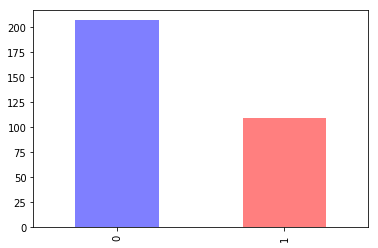

In [43]:
math_ftrain['romantic'].value_counts().plot(kind='bar', color=['b', 'r'], alpha=0.5)

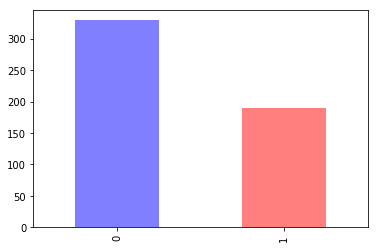

In [44]:
port_ftrain['romantic'].value_counts().plot(kind='bar', color=['b', 'r'], alpha=0.5)

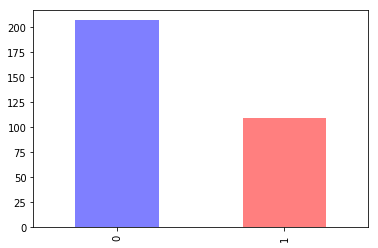

In [45]:
math_ftrain['romantic'].value_counts().plot(kind='bar', color=['b', 'r'], alpha=0.5)

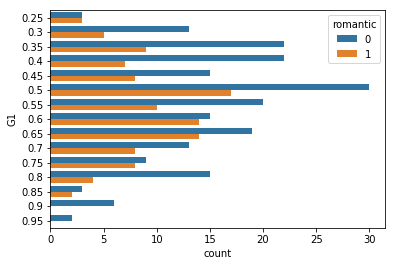

In [46]:
sns.countplot(y='G1', hue='romantic', data = math_ftrain)

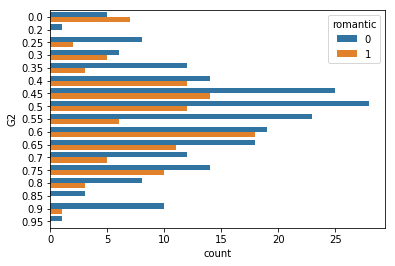

In [47]:
sns.countplot(y='G2', hue='romantic', data = math_ftrain)

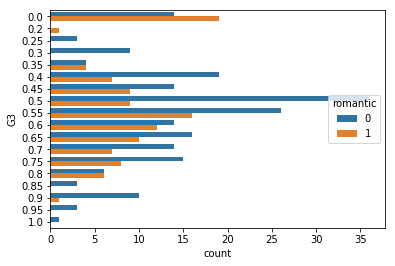

In [48]:
sns.countplot(y='G3', hue='romantic', data = math_ftrain)

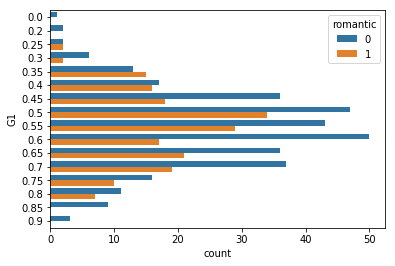

In [49]:
sns.countplot(y='G1', hue='romantic', data = port_ftrain)

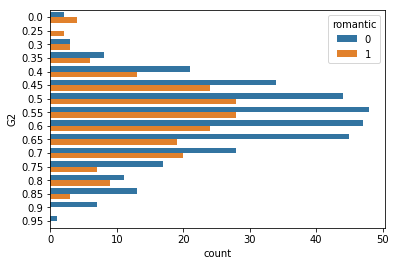

In [50]:
sns.countplot(y='G2', hue='romantic', data = port_ftrain)

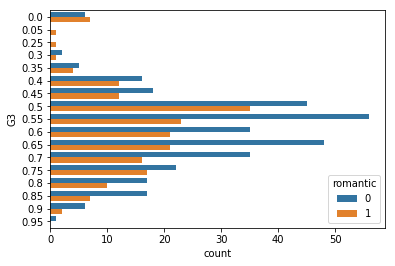

In [51]:
sns.countplot(y='G3', hue='romantic', data = port_ftrain)

In [52]:
math_ftrain.shape[0]

316

In [53]:
port_ftrain['romantic'].value_counts()

0    329
1    190
Name: romantic, dtype: int64

In [54]:
port_ftrain.shape[0]

519

In [55]:
math_ftrain.head()

,age,absences,G1,G2,G3,school,sex,address,famsize,Pstatus,...,Walc_1,Walc_2,Walc_3,Walc_4,Walc_5,health_1,health_2,health_3,health_4,health_5
181,16,2,0.60,0.65,0.60,1,1,1,1,0,...,0,1,0,0,0,0,0,1,0,0
194,16,0,0.65,0.70,0.70,1,1,1,1,0,...,1,0,0,0,0,0,0,1,0,0
173,16,0,0.40,0.35,0.00,1,0,1,1,0,...,1,0,0,0,0,0,0,1,0,0
63,16,2,0.50,0.45,0.45,1,0,1,1,0,...,0,0,0,1,0,0,0,0,1,0
253,16,0,0.40,0.45,0.40,1,1,0,1,0,...,0,0,1,0,0,0,0,1,0,0


In [56]:
# Need to specify features to use as predictors... Take out some dummies for One-Hot Encoding, as well as taking out G1/2
X_train_cols.remove('G1')
X_train_cols.remove('G2')

# Remove target from X_train columns
# Could generalize code more w/ .pop() function?
X_train_cols.remove('romantic')
y_train_col = 'romantic'

# Check
print(X_train_cols)
print(y_train_col)

['age', 'absences', 'G3', 'school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'Medu_1', 'Medu_2', 'Medu_3', 'Medu_4', 'Fedu_1', 'Fedu_2', 'Fedu_3', 'Fedu_4', 'Mjob_at_home', 'Mjob_health', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_reputation', 'guardian_father', 'guardian_mother', 'traveltime_2', 'traveltime_3', 'traveltime_4', 'studytime_2', 'studytime_3', 'studytime_4', 'failures_1', 'failures_2', 'failures_3', 'famrel_2', 'famrel_3', 'famrel_4', 'famrel_5', 'freetime_2', 'freetime_3', 'freetime_4', 'freetime_5', 'goout_2', 'goout_3', 'goout_4', 'goout_5', 'Dalc_2', 'Dalc_3', 'Dalc_4', 'Dalc_5', 'Walc_2', 'Walc_3', 'Walc_4', 'Walc_5', 'health_2', 'health_3', 'health_4', 'health_5']
romantic


In [57]:
# Create X and y training dataframes for each group...
X_m = math_ftrain[X_train_cols]
X_p = port_ftrain[X_train_cols]

y_m = math_ftrain[y_train_col]
y_p = port_ftrain[y_train_col]

X_m.head()

,age,absences,G3,school,sex,address,famsize,Pstatus,schoolsup,famsup,...,Dalc_4,Dalc_5,Walc_2,Walc_3,Walc_4,Walc_5,health_2,health_3,health_4,health_5
181,16,2,0.60,1,1,1,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
194,16,0,0.70,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
173,16,0,0.00,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
63,16,2,0.45,1,0,1,1,0,1,1,...,0,0,0,0,1,0,0,0,1,0
253,16,0,0.40,1,1,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [58]:
y_p.head()

332    0
29     1
302    0
286    0
554    1
Name: romantic, dtype: int64

In [59]:
clf = LogisticRegressionCV(cv=RepeatedStratifiedKFold(), penalty='l2', scoring='accuracy', class_weight='balanced', random_state=0)

m_model = clf.fit(X_m, y_m)
#p_model = clf.fit(X_p, y_p)

#m_clf.predict(X_m)

# set threshold...
m_thresh = 0.7 

m_probs = m_model.predict_proba(X_m)

m_labels = np.where(m_probs >= m_thresh, 1, 0)

acc_m = m_model.score(X_m, y_m)

print("Accuracy: {}".format(acc_m))


/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Incre

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Incre

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Incre

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Incre

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Incre

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Incre

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Incre

Accuracy: 0.6360759493670886


/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Incre

In [60]:
print("Accuracy: {}".format(acc_m))

Accuracy: 0.6360759493670886


In [61]:
m_model.coef_

array([[ 3.39964255e-03,  1.26624109e-02, -4.84514872e-04,
        -3.93311887e-04, -5.37378162e-04,  2.15218310e-04,
        -4.28418090e-04,  1.75301603e-04, -5.71652250e-04,
         2.37281991e-05, -3.20115225e-04,  2.17039960e-04,
         9.57755381e-05, -3.98631225e-04,  2.43407664e-04,
        -9.64394595e-05,  2.49085545e-04, -3.51323365e-04,
         2.72560669e-04,  3.30456152e-04, -6.72018787e-04,
         8.94543889e-05,  1.77637374e-04,  2.85624539e-04,
         7.96353321e-05, -8.29911978e-08, -3.41154726e-04,
         2.10304274e-04,  5.64245078e-05,  2.61268361e-04,
         2.00696041e-04, -1.69865173e-04,  1.65203041e-04,
        -2.11681858e-04, -3.04986702e-04, -7.38440435e-05,
        -1.59443000e-04, -1.29396114e-04,  2.17183119e-04,
         8.89549440e-04,  4.59510760e-04, -4.56542665e-04,
         1.19653666e-04,  4.61596991e-04,  6.82864863e-05,
         1.84749054e-05, -3.32594348e-04,  7.05498656e-04,
        -6.06522109e-04,  2.98115064e-04, -3.29831362e-0

In [62]:
m_model.classes_

array([0, 1])

In [63]:
m_model.intercept_

array([-0.136135])

In [64]:
m_model.coefs_paths_

{1: array([[[ 1.80311113e-03,  9.95183549e-03, -4.74209766e-04, ...,
          -2.95875922e-04, -8.16445059e-05, -9.41558657e-02],
         [ 1.20148089e-02,  2.31096824e-02, -3.84014955e-03, ...,
          -2.14691564e-03, -4.89809996e-04, -3.50151653e-01],
         [ 6.07695406e-02,  2.72506965e-02, -2.88984963e-02, ...,
          -1.54761618e-02, -1.23334226e-03, -1.20187821e+00],
         ...,
         [ 1.15936966e-01,  2.71342204e-02, -2.82165373e+00, ...,
          -5.85456462e-02,  3.49451583e-01,  2.83405771e+00],
         [ 1.00329104e-01,  2.73510221e-02, -2.86162850e+00, ...,
           2.60882358e-04,  4.29377822e-01,  3.15170805e+00],
         [ 7.12119083e-02,  2.60721847e-02, -2.89075065e+00, ...,
          -9.45257346e-02,  3.36075796e-01,  4.58499068e+00]],
 
        [[ 3.13919180e-03,  1.07210456e-02, -2.72719547e-04, ...,
          -1.14872980e-04,  5.17614350e-05, -1.13588724e-01],
         [ 2.13221018e-02,  2.69959318e-02, -2.19478979e-03, ...,
          -8.24294

In [65]:
m_model.n_iter_

array([[[ 14,  20,  31,  70, 100, 100, 100, 100, 100, 100],
        [ 16,  21,  32,  73, 100, 100, 100, 100, 100, 100],
        [ 16,  20,  31,  69, 100, 100, 100, 100, 100, 100],
        [ 17,  16,  23,  76, 100, 100, 100, 100, 100, 100],
        [ 17,  20,  25,  68, 100, 100, 100, 100, 100, 100],
        [ 16,  19,  31,  75, 100, 100, 100, 100, 100, 100],
        [ 15,  20,  35,  70, 100, 100, 100, 100, 100, 100],
        [ 16,  20,  30,  74, 100, 100, 100, 100, 100, 100],
        [ 16,  20,  31,  77, 100, 100, 100, 100, 100, 100],
        [ 17,  20,  26,  64, 100, 100, 100, 100, 100, 100],
        [ 17,  21,  32,  52, 100, 100, 100, 100, 100, 100],
        [ 17,  16,  24,  71, 100, 100, 100, 100, 100, 100],
        [ 15,  20,  26,  58, 100, 100, 100, 100, 100, 100],
        [ 16,  20,  31,  70, 100, 100, 100, 100, 100, 100],
        [ 17,  20,  39,  74, 100, 100, 100, 100, 100, 100],
        [ 17,  18,  30,  82,  97, 100, 100, 100, 100, 100],
        [ 15,  19,  29,  68, 100, 100, 1

In [66]:
m_model.scores_

{1: array([[0.71875   , 0.703125  , 0.671875  , 0.625     , 0.65625   ,
         0.625     , 0.578125  , 0.640625  , 0.59375   , 0.625     ],
        [0.609375  , 0.59375   , 0.59375   , 0.578125  , 0.5625    ,
         0.5625    , 0.53125   , 0.53125   , 0.546875  , 0.515625  ],
        [0.55555556, 0.55555556, 0.55555556, 0.53968254, 0.49206349,
         0.58730159, 0.63492063, 0.63492063, 0.63492063, 0.63492063],
        [0.65079365, 0.6031746 , 0.61904762, 0.63492063, 0.61904762,
         0.55555556, 0.52380952, 0.53968254, 0.55555556, 0.55555556],
        [0.61290323, 0.58064516, 0.53225806, 0.5       , 0.5483871 ,
         0.58064516, 0.59677419, 0.62903226, 0.61290323, 0.61290323],
        [0.5625    , 0.546875  , 0.484375  , 0.46875   , 0.5       ,
         0.59375   , 0.546875  , 0.515625  , 0.53125   , 0.53125   ],
        [0.609375  , 0.625     , 0.609375  , 0.578125  , 0.546875  ,
         0.59375   , 0.625     , 0.671875  , 0.671875  , 0.671875  ],
        [0.66666667, 0.6

In [67]:
m_model.get_params()

{'Cs': 10,
 'class_weight': 'balanced',
 'cv': <sklearn.model_selection._split.RepeatedStratifiedKFold at 0x1c1e82e518>,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 0,
 'refit': True,
 'scoring': 'accuracy',
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0}

In [68]:
def k_fold_CV(X, y, desc, n_folds = 5, cw = 'balanced', threshold = 0.5):
    skf = StratifiedKFold(n_splits=n_folds, shuffle=False)
    auc_test = []
    accuracy_test = []
    precision_test = []
    recall_test = []
    f1_score_test = []
    auc_train = []
    accuracy_train = []
    precision_train = []
    recall_train = []
    f1_score_train = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        model = LogisticRegression(class_weight=cw)
        model.fit(X_train, y_train)
        probs = model.predict_proba(X_test)[:, 1]
        probabilities = np.where(probs >= threshold, 1, 0)
        probs_train = model.predict_proba(X_train)[:, 1]
        probabilities_train = np.where(probs_train >= threshold, 1, 0)
        auc_test.append(metrics.roc_auc_score(y_test, probs))
        accuracy_test.append(metrics.accuracy_score(y_test, probabilities))
        precision_test.append(metrics.precision_score(y_test, probabilities))
        recall_test.append(metrics.recall_score(y_test, probabilities))
        f1_score_test.append(metrics.f1_score(y_test, probabilities))
        auc_train.append(metrics.roc_auc_score(y_train, probs_train))
        accuracy_train.append(metrics.accuracy_score(y_train, probabilities_train))
        precision_train.append(metrics.precision_score(y_train, probabilities_train))
        recall_train.append(metrics.recall_score(y_train, probabilities_train))
        f1_score_train.append(metrics.f1_score(y_train, probabilities_train))
    return [np.mean(auc_test), np.mean(accuracy_test), np.mean(precision_test),np.mean(recall_test), np.mean(f1_score_test), np.mean(auc_train), np.mean(accuracy_train), np.mean(precision_train), np.mean(recall_train), np.mean(f1_score_train), desc]

In [69]:
print(k_fold_CV(X_m, y_m, desc='all, test', n_folds = 5, cw = 'balanced', threshold = 0.5))

[0.5115880054904445, 0.5092213901689708, 0.33620116209176515, 0.4311688311688312, 0.37664957264957266, 0.8309583370052834, 0.7484267035790487, 0.6099681627445361, 0.7500783699059561, 0.6726136973496983, 'all, test']


/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

In [70]:
# TARGET ALWAYS 'ROMANTIC'
y_col = 'romantic'

# FULL MODEL
X_cols1 = ['age', 'absences', 'G3', 'school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'Medu_1', 'Medu_2', 'Medu_3', 'Medu_4', 'Fedu_1', 'Fedu_2', 'Fedu_3', 'Fedu_4', 'Mjob_at_home', 'Mjob_health', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_reputation', 'guardian_father', 'guardian_mother', 'traveltime_2', 'traveltime_3', 'traveltime_4', 'studytime_2', 'studytime_3', 'studytime_4', 'failures_1', 'failures_2', 'failures_3', 'famrel_2', 'famrel_3', 'famrel_4', 'famrel_5', 'freetime_2', 'freetime_3', 'freetime_4', 'freetime_5', 'goout_2', 'goout_3', 'goout_4', 'goout_5', 'Dalc_2', 'Dalc_3', 'Dalc_4', 'Dalc_5', 'Walc_2', 'Walc_3', 'Walc_4', 'Walc_5', 'health_2', 'health_3', 'health_4', 'health_5']

# SMALLER MODEL - TAKING OUT SOME SOCIAL DEMS
X_cols2 = ['age', 'absences', 'G3', 'school', 'sex', 'address', 'famsize', 'schoolsup', 'activities', 'higher', 'reason_course', 'reason_home', 'reason_reputation', 'studytime_2', 'studytime_3', 'studytime_4', 'failures_1', 'failures_2', 'failures_3', 'freetime_2', 'freetime_3', 'freetime_4', 'freetime_5', 'health_2', 'health_3', 'health_4', 'health_5']

# SMALLEST MODEL - TAKING OUT EVERYTHING EXCEPT ACADEMIC OUTCOMES
X_cols3 = ['absences', 'G3', 'activities', 'higher', 'studytime_2', 'studytime_3', 'studytime_4', 'failures_1', 'failures_2', 'failures_3', 'freetime_2', 'freetime_3', 'freetime_4', 'freetime_5', 'health_2', 'health_3', 'health_4', 'health_5']

In [71]:
# Create X and y training dataframes for each group...
X_m1 = math_ftrain[X_cols1]
X_p1 = port_ftrain[X_cols1]

X_m2 = math_ftrain[X_cols2]
X_p2 = port_ftrain[X_cols2]

X_m3 = math_ftrain[X_cols3]
X_p3 = port_ftrain[X_cols3]

y_m = math_ftrain[y_col]
y_p = port_ftrain[y_col]

print(X_m1.shape)
print(X_p1.shape)
print(X_m2.shape)
print(X_p2.shape)
print(X_m3.shape)
print(X_p3.shape)

(316, 69)
(519, 69)
(316, 27)
(519, 27)
(316, 18)
(519, 18)


In [72]:
# Put models into lists so we can iterate through easily...
m_models = [(X_m1, 'all features'), (X_m2, 'minimal social features'), (X_m3, 'only educ outcome features')]
p_models = [(X_p1, 'all features'), (X_p2, 'minimal social features'), (X_p3, 'only educ outcome features')]

In [73]:
m_cv_results = dict()
p_cv_results = dict()

for model, m_desc in m_models:
    model_metrics = k_fold_CV(model, y_m, desc=m_desc, n_folds = 5, cw = 'balanced', threshold = 0.5)
    m_cv_results[m_desc] = model_metrics

for model, p_desc in p_models:
    model_metrics = k_fold_CV(model, y_p, desc=p_desc, n_folds = 5, cw = 'balanced', threshold = 0.5)
    p_cv_results[p_desc] = model_metrics   

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

In [74]:
m_acc_scores = []
for key, value in m_cv_results.items():
    m_acc_scores.append(value[1])

print(m_acc_scores)
print(max(m_acc_scores))

[0.5092213901689708, 0.5630952380952381, 0.5573572708653354]
0.5630952380952381


In [75]:
print(m_cv_results)

{'all features': [0.5115880054904445, 0.5092213901689708, 0.33620116209176515, 0.4311688311688312, 0.37664957264957266, 0.8309583370052834, 0.7484267035790487, 0.6099681627445361, 0.7500783699059561, 0.6726136973496983, 'all features'], 'minimal social features': [0.5977615880054905, 0.5630952380952381, 0.3944433638443936, 0.5229437229437229, 0.4450992461751193, 0.736184455691103, 0.6669406195767031, 0.5127663110138084, 0.6629049111807731, 0.5779511359980807, 'minimal social features'], 'only educ outcome features': [0.6017896737408933, 0.5573572708653354, 0.3981684981684982, 0.5238095238095238, 0.4497749098941983, 0.7040728063770232, 0.6456121838525124, 0.48918338959857444, 0.6353970741901778, 0.5525777041510671, 'only educ outcome features']}


In [76]:
m_f1_scores = []
for key, value in m_cv_results.items():
    m_f1_scores.append(value[4])

print(m_f1_scores)
print(max(m_f1_scores))

[0.37664957264957266, 0.4450992461751193, 0.4497749098941983]
0.4497749098941983


In [77]:
m_auc_scores = []
for key, value in m_cv_results.items():
    m_auc_scores.append(value[0])

print(m_auc_scores)
print(max(m_auc_scores))

[0.5115880054904445, 0.5977615880054905, 0.6017896737408933]
0.6017896737408933


In [78]:
m_cv_results_t7 = dict()

for model, m_desc in m_models:
    model_metrics = k_fold_CV(model, y_m, desc=m_desc, n_folds = 5, cw = 'balanced', threshold = 0.7)
    m_cv_results_t7[m_desc] = model_metrics

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

In [79]:
m_acc_scores = []
for key, value in m_cv_results_t7.items():
    m_acc_scores.append(value[1])

print(m_acc_scores)
print(max(m_acc_scores))

[0.6265472990271377, 0.6900985663082437, 0.6584005376344085]
0.6900985663082437


In [80]:
m_f1_scores = []
for key, value in m_cv_results_t7.items():
    m_f1_scores.append(value[4])

print(m_f1_scores)
print(max(m_f1_scores))

[0.28789630960572926, 0.27829978862236926, 0.18308723804375976]
0.28789630960572926


In [81]:
m_auc_scores = []
for key, value in m_cv_results_t7.items():
    m_auc_scores.append(value[0])

print(m_auc_scores)
print(max(m_auc_scores))

[0.5115880054904445, 0.5977615880054905, 0.6017896737408933]
0.6017896737408933


In [82]:
m_prec_scores = []
for key, value in m_cv_results.items():
    m_prec_scores.append(value[2])

print(m_prec_scores)
print(max(m_prec_scores))

[0.33620116209176515, 0.3944433638443936, 0.3981684981684982]
0.3981684981684982


In [83]:
m_prec_scores = []
for key, value in m_cv_results_t7.items():
    m_prec_scores.append(value[2])

print(m_prec_scores)
print(max(m_prec_scores))

[0.4162087035771246, 0.6888888888888889, 0.6024242424242424]
0.6888888888888889


In [199]:
p_cv_results_t7 = dict()

for model, p_desc in p_models:
    model_metrics = k_fold_CV(model, y_p, desc=m_desc, n_folds = 5, cw = 'balanced', threshold = 0.7)
    p_cv_results_t7[p_desc] = model_metrics

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

In [200]:
p_acc_scores = []
for key, value in p_cv_results_t7.items():
    p_acc_scores.append(value[1])

print(p_acc_scores)
print(max(p_acc_scores))

[0.6511949215832711, 0.6376773711725168, 0.6493091859596715]
0.6511949215832711


In [201]:
p_prec_scores = []
for key, value in p_cv_results_t7.items():
    p_prec_scores.append(value[2])

print(p_prec_scores)
print(max(p_prec_scores))

[0.5499016772700984, 0.5184766214177978, 0.59992673992674]
0.59992673992674


In [88]:
m_cross_val_model = LogisticRegression(class_weight='balanced', random_state=0)
scores = cross_val_score(m_cross_val_model, X_m, 
         y_m, cv=3)
print(np.mean(scores))

0.5253069781371668


/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [96]:
m_scores = []
for X_m, desc in m_models:
    m_cross_val_model = LogisticRegression(class_weight='balanced', random_state=0)
    scores = cross_val_score(m_cross_val_model, X_m, 
             y_m, scoring='accuracy', cv=3)
    m_scores.append(np.mean(scores))
    print(desc, np.mean(scores))
print(max(m_scores))

all features 0.5253069781371668
minimal social features 0.5442647499251273
only educ outcome features 0.5729260257562144
0.5729260257562144


/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

In [98]:
m_scores = []
for X_m, desc in m_models:
    m_cross_val_model = LogisticRegression(class_weight='balanced', random_state=0)
    scores = cross_val_score(m_cross_val_model, X_m, 
             y_m, scoring='precision', cv=3)
    m_scores.append(np.mean(scores))
    print(desc, np.mean(scores))
print(max(m_scores))

all features 0.34997472194135487
minimal social features 0.382887612797375
only educ outcome features 0.4194283968599469
0.4194283968599469


/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

In [97]:
p_scores = []
for X_p, desc in p_models:
    p_cross_val_model = LogisticRegression(class_weight='balanced', random_state=0)
    scores = cross_val_score(p_cross_val_model, X_p, 
             y_p, scoring='accuracy', cv=3)
    p_scores.append(np.mean(scores))
    print(desc, np.mean(scores))
print(max(p_scores))

all features 0.5490553049863024
minimal social features 0.593417651303398
only educ outcome features 0.595489289902703
0.595489289902703


/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

In [99]:
p_scores = []
for X_p, desc in p_models:
    p_cross_val_model = LogisticRegression(class_weight='balanced', random_state=0)
    scores = cross_val_score(p_cross_val_model, X_p, 
             y_p, scoring='precision', cv=3)
    p_scores.append(np.mean(scores))
    print(desc, np.mean(scores))
print(max(p_scores))

all features 0.41458072286816056
minimal social features 0.4557607051582955
only educ outcome features 0.4602279988753419
0.4602279988753419


/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

In [100]:
# penalty specifies the norm in the penalization
penalty = ['l1', 'l2']
# C is the inverese of regularization parameter
C = np.logspace(0, 4, 10)
# thresh is the threshold at which we choose the labels - let's try 10 
# thresh = np.linspace(0, 1, 10)
random_state=[0]
# creating a dictionary of hyperparameters
hyperparameters = dict(C=C, penalty=penalty, random_state=random_state)

In [103]:
model = LogisticRegression(class_weight='balanced', random_state=0)
model.fit(X_m3, y_m)

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=0,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [104]:
clf = GridSearchCV(estimator = model, param_grid = hyperparameters, 
                   cv=5)
best_model = clf.fit(X_m3, y_m)
print('Best Penalty:', best_model.best_estimator_.get_params() ['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])
# print('Best thresh:', best_model.best_estimator_.get_params()['C'])

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

Best Penalty: l1
Best C: 7.742636826811269


/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default o

Best Penalty: l1
Best C: 7.742636826811269

In [ ]:
p_model = LogisticRegression(class_weight='balanced', random_state=0)
p_model.fit(X_p3, y_p)

In [105]:
clf = GridSearchCV(estimator = model, param_grid = hyperparameters, 
                   cv=5)
best_model = clf.fit(X_p3, y_p)
print('Best Penalty:', best_model.best_estimator_.get_params() ['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])
# print('Best thresh:', best_model.best_estimator_.get_params()['C'])

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

Best Penalty: l2
Best C: 1.0


/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

Best Penalty: l2
Best C: 1.0

In [106]:
X_test_m = math_holdout[X_cols3]
X_test_p = port_holdout[X_cols3]

y_test_m = math_holdout[y_col]
y_test_p = port_holdout[y_col]

print(X_test_m.shape)
print(X_test_p.shape)
print(y_test_m.shape)
print(y_test_p.shape)

(79, 18)
(130, 18)
(79,)
(130,)


In [202]:
# FINAL FITTING, YAY

m_model = LogisticRegression(penalty='l1', C=7.742636826811269, class_weight='balanced', random_state=0).fit(X_m3, y_m)

m_probs = m_model.predict_proba(X_test_m)[:, 1]
threas = 0.7

m_pred = np.where(m_probs >= threas, 1, 0)

# cost_per_observation = y * np.log(probs) + (1 - y) * np.log(1 - probs)
# ridge_penalty = np.sum(coeffs*coeffs)
# if has_intercept:
#     ridge_penalty -= coeffs[0]*coeffs[0]
# return -np.sum(cost_per_observation) + lam * ridge_penalty


/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [207]:
m_coeffs = m_model.coef_
m_coeffs

array([[ 0.04, -1.17,  0.13, -1.11,  0.97,  1.13, -0.21, -0.18,  1.23,
        -0.2 ,  0.93,  0.36,  0.51,  1.09, -0.13,  0.23, -0.2 ,  0.12]])

In [214]:
m_results = dict()
for idx in range(len(m_coeffs[0])):
    m_results[X_cols3[idx]] = m_coeffs[0][idx].round(3)
print(m_results)


{'absences': 0.038, 'G3': -1.166, 'activities': 0.134, 'higher': -1.11, 'studytime_2': 0.974, 'studytime_3': 1.134, 'studytime_4': -0.213, 'failures_1': -0.182, 'failures_2': 1.231, 'failures_3': -0.198, 'freetime_2': 0.925, 'freetime_3': 0.361, 'freetime_4': 0.513, 'freetime_5': 1.094, 'health_2': -0.134, 'health_3': 0.234, 'health_4': -0.2, 'health_5': 0.122}


In [217]:
p_model = LogisticRegression(penalty='l2', C=1.0, class_weight='balanced', random_state=0).fit(X_p3, y_p)

p_probs = p_model.predict_proba(X_test_p)[:, 1]
threas = 0.7

p_pred = np.where(p_probs >= threas, 1, 0)

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [218]:
p_coeffs = p_model.coef_
p_coeffs

array([[ 0.04, -0.56,  0.23, -0.66,  0.63,  1.  , -0.62,  0.61,  0.13,
        -0.09,  0.64,  0.25,  0.05,  0.66, -0.29, -0.21, -0.51, -0.  ]])

In [219]:
p_results = dict()
for idx in range(len(p_coeffs[0])):
    p_results[X_cols3[idx]] = p_coeffs[0][idx].round(3)
print(p_results)


{'absences': 0.044, 'G3': -0.558, 'activities': 0.229, 'higher': -0.657, 'studytime_2': 0.63, 'studytime_3': 1.0, 'studytime_4': -0.62, 'failures_1': 0.606, 'failures_2': 0.131, 'failures_3': -0.087, 'freetime_2': 0.635, 'freetime_3': 0.253, 'freetime_4': 0.046, 'freetime_5': 0.663, 'health_2': -0.294, 'health_3': -0.215, 'health_4': -0.508, 'health_5': -0.002}


In [215]:
np.e**0.038

1.0387312328784977

In [220]:
np.e**-0.558

0.5723526251566332

In [ ]:
m_model = LogisticRegression(penalty='l1', C=7.742636826811269, class_weight='balanced', random_state=0).fit(X_m3, y_m)

m_probs = m_model.predict_proba(X_test_m)[:, 1]
threas = 0.7

m_pred = np.where(m_probs >= threas, 1, 0)

In [111]:
def roc_curve(probabilities, labels):
    '''
    INPUT: numpy array, numpy array
    OUTPUT: list, list, list

    Take a numpy array of the predicted probabilities and a numpy array of the
    true labels.
    Return the True Positive Rates, False Positive Rates and Thresholds for the
    ROC curve.
    '''

    thresholds = np.sort(probabilities)

    tprs = []
    fprs = []

    num_positive_cases = sum(labels)
    num_negative_cases = len(labels) - num_positive_cases

    for threshold in thresholds:
        # With this threshold, give the prediction of each instance
        predicted_positive = probabilities >= threshold
        # Calculate the number of correctly predicted positive cases
        true_positives = np.sum(predicted_positive * labels)
        # Calculate the number of incorrectly predicted positive cases
        false_positives = np.sum(predicted_positive) - true_positives
        # Calculate the True Positive Rate
        tpr = true_positives / float(num_positive_cases)
        # Calculate the False Positive Rate
        fpr = false_positives / float(num_negative_cases)

        fprs.append(fpr)
        tprs.append(tpr)

    return tprs, fprs, thresholds.tolist()

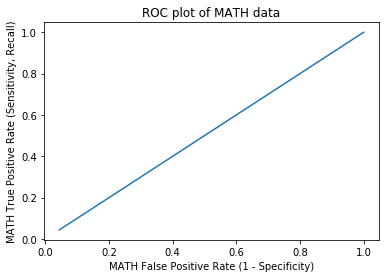

In [112]:
m_tpr, m_fpr, m_thresholds = roc_curve(m_probs, y_test_m)

plt.plot(m_tpr, m_tpr)
plt.xlabel("MATH False Positive Rate (1 - Specificity)")
plt.ylabel("MATH True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot of MATH data")
plt.show()

In [141]:
from sklearn import metrics

def run_data(data, comp, penalty, C, X_train, X_test, y_train, y_test):
    model = LogisticRegression(penalty=penalty, C=C, class_weight='balanced', random_state=0)
    model.fit(X_train, y_train)
    
    if comp == 'train':
        probabilities = model.predict_proba(X_train)[:, 1]
        #tpr, fpr, thresholds = roc_curve(probabilities, y_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_train, probabilities, pos_label=1)
        auc = metrics.roc_auc_score(y_train, probabilities) # note we are scoring on our training data!
    else:
        probabilities = model.predict_proba(X_test)[:, 1]
        #tpr, fpr, thresholds = roc_curve(probabilities, y_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, probabilities, pos_label=1)
        auc = metrics.roc_auc_score(y_test, probabilities) # note we are scoring on our training data!
        
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
         label='Luck')
    ax.plot(fpr, tpr, color='b', lw=2, label='Model')
    ax.set_xlabel("False Positive Rate (1 - Specificity)", fontsize=20)
    ax.set_ylabel("True Positive Rate (Sensitivity, Recall)", fontsize=20)
    if data == 'math':
        ax.set_title("ROC plot of School data in Math", fontsize=24)
    else:
        ax.set_title("ROC plot of School data in Portuguese", fontsize=24)
    ax.text(0.7, 0.3, " ".join(["AUC:",str(auc.round(3))]), fontsize=20)
    ax.legend(fontsize=24);
    plt.show()
    
    return probabilities, auc, fpr, tpr

  
    
# Plot the ROC
# fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot(111)
# ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
#          label='Luck')
# ax.plot(fpr, tpr, color='b', lw=2, label='Model')
# ax.set_xlabel("False Positive Rate", fontsize=20)
# ax.set_ylabel("True Postive Rate", fontsize=20)
# ax.set_title("ROC curve", fontsize=24)
# ax.text(0.3, 0.7, " ".join(["AUC:",str(auc.round(3))]), fontsize=20)
# ax.legend(fontsize=24);

In [135]:
m_penalty = 'l1'
m_C = 7.742636826811269

p_penalty = 'l2'
p_C = 1.0

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


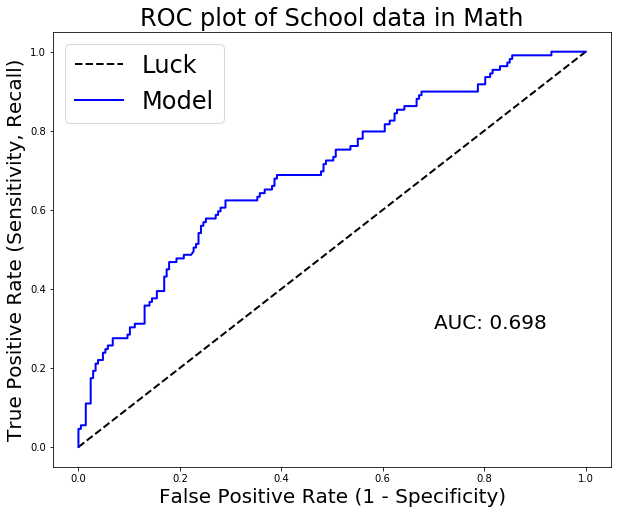

In [142]:
m_prob1, m_auc1, m_fpr1, m_tpr1 = run_data('math', 'train', m_penalty, m_C, X_m3, X_test_m, y_m, y_test_m)

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


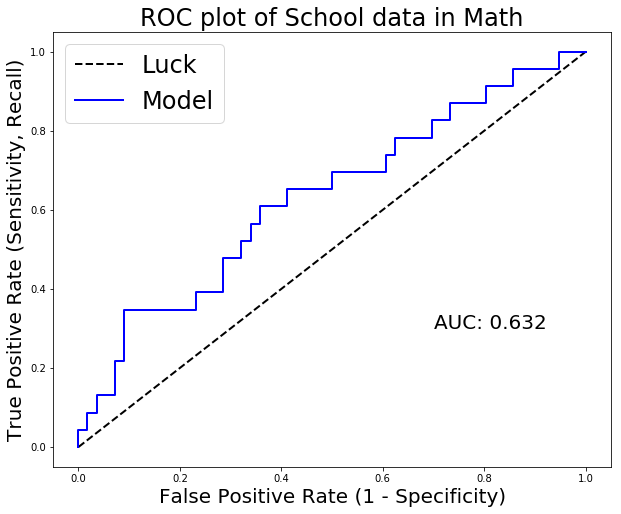

In [143]:
m_prob2, m_auc2, m_fpr2, m_tpr2 = run_data('math', 'test', m_penalty, m_C, X_m3, X_test_m, y_m, y_test_m)

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


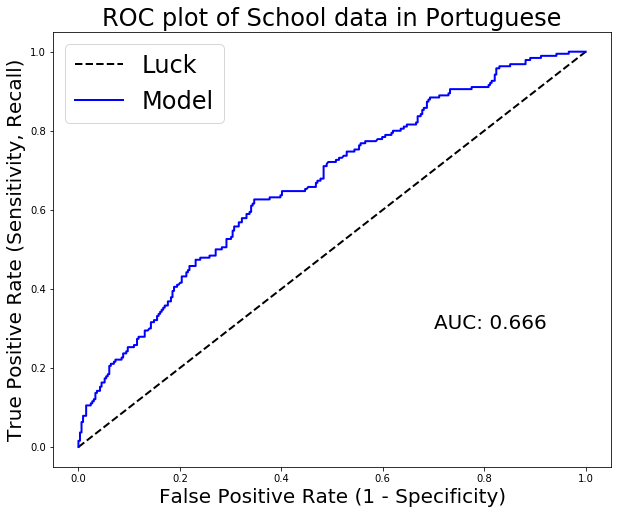

In [144]:
p_prob1, p_auc1, p_fpr1, p_tpr1 = run_data('port', 'train', p_penalty, p_C, X_p3, X_test_p, y_p, y_test_p)

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


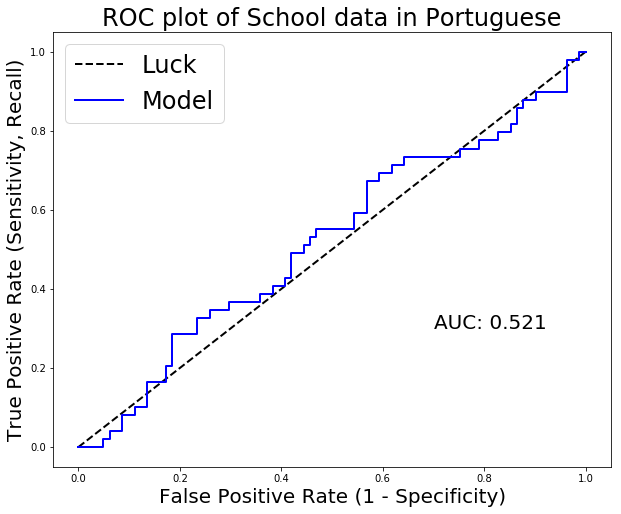

In [145]:
p_prob2, p_auc2, p_fpr2, p_tpr2 = run_data('port', 'test', p_penalty, p_C, X_p3, X_test_p, y_p, y_test_p)

In [196]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, ax, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    font_size = 24
    p = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title,fontsize=font_size)
    
    plt.colorbar(p)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center", size = font_size,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    ax.set_ylabel('True label',fontsize=font_size)
    ax.set_xlabel('Predicted label',fontsize=font_size)

In [185]:
threas = 0.5

m_pred1 = np.where(m_prob1 >= threas, 1, 0)
p_pred1 = np.where(p_prob1 >= threas, 1, 0)
m_pred2 = np.where(m_prob2 >= threas, 1, 0)
p_pred2 = np.where(p_prob2 >= threas, 1, 0)

Text(33.0, 0.5, 'Actual classes')

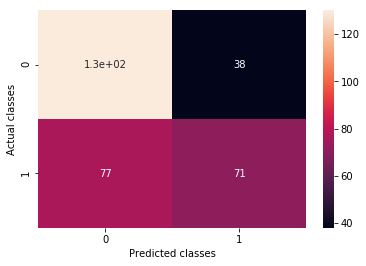

In [186]:
m_cfm1 = confusion_matrix(m_pred1, y_m.values)
sns.heatmap(m_cfm1, annot=True)
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')

Text(33.0, 0.5, 'Actual classes')

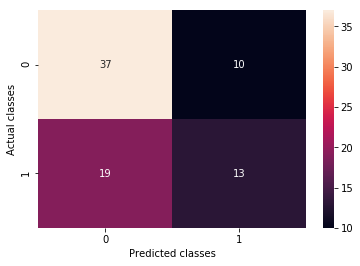

In [190]:
m_cfm2 = confusion_matrix(m_pred2, y_test_m.values)
sns.heatmap(m_cfm2, annot=True)
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')

Text(33.0, 0.5, 'Actual classes')

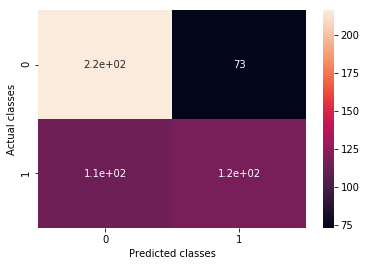

In [191]:
p_cfm1 = confusion_matrix(p_pred1, y_p.values)
sns.heatmap(p_cfm1, annot=True)
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')

Text(33.0, 0.5, 'Actual classes')

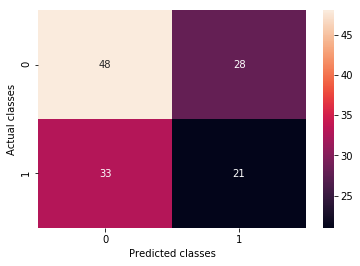

In [192]:
p_cfm2 = confusion_matrix(p_pred2, y_test_p.values)
sns.heatmap(p_cfm2, annot=True)
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')

In [221]:
threas = 0.7

m_pred1 = np.where(m_prob1 >= threas, 1, 0)
p_pred1 = np.where(p_prob1 >= threas, 1, 0)
m_pred2 = np.where(m_prob2 >= threas, 1, 0)
p_pred2 = np.where(p_prob2 >= threas, 1, 0)

In [225]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(m_pred2, y_test_m.values)
np.set_printoptions(precision=2)
print("| TN | FP |\n| FN | TP |\n")
print(cnf_matrix)

| TN | FP |
| FN | TP |

[[54 20]
 [ 2  3]]


Confusion matrix, without normalization
[[54 20]
 [ 2  3]]


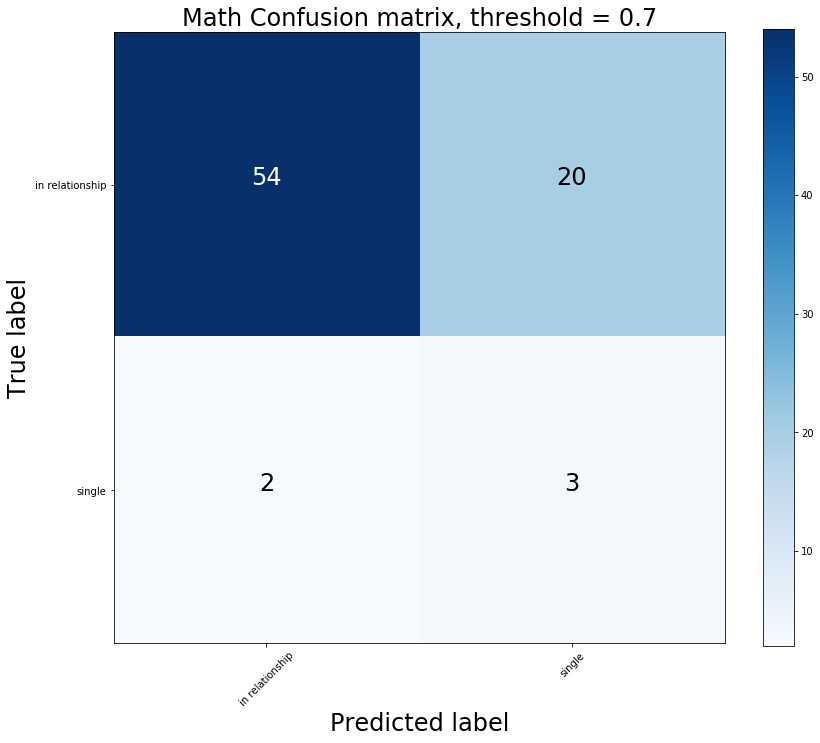

In [226]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
ax.grid(False)
class_names = ["in relationship","single"]
plot_confusion_matrix(cnf_matrix, ax, classes=class_names,normalize=False,
                      title='Math Confusion matrix, threshold = 0.7')

Confusion matrix, without normalization
[[37 10]
 [19 13]]


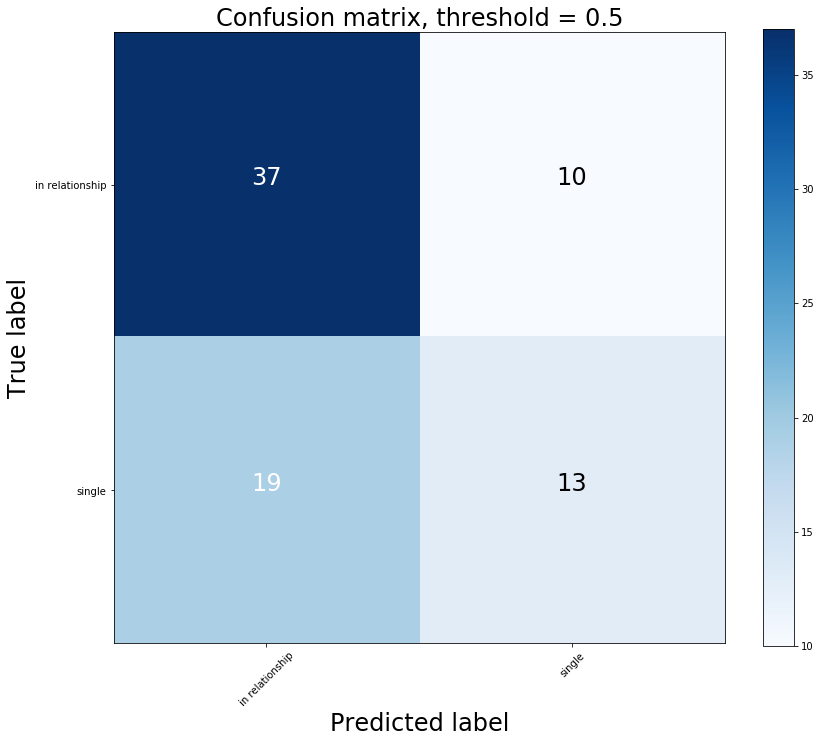

In [182]:
cnf_matrix = confusion_matrix(m_pred2, y_test_m.values)
np.set_printoptions(precision=2)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
ax.grid(False)
class_names = ["in relationship","single"]
plot_confusion_matrix(cnf_matrix, ax, classes=class_names,normalize=False,
                      title='Confusion matrix, threshold = 0.5')

Confusion matrix, without normalization
[[72 44]
 [ 9  5]]


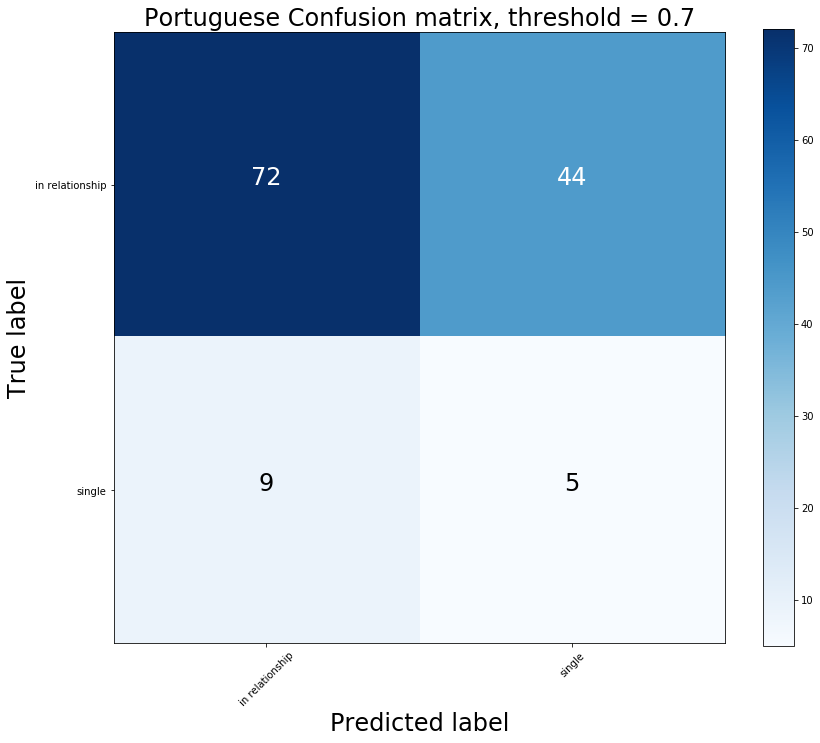

In [228]:
cnf_matrix = confusion_matrix(p_pred2, y_test_p.values)
np.set_printoptions(precision=2)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
ax.grid(False)
class_names = ["in relationship","single"]
plot_confusion_matrix(cnf_matrix, ax, classes=class_names,normalize=False,
                      title='Portuguese Confusion matrix, threshold = 0.7')

Confusion matrix, without normalization
[[72 44]
 [ 9  5]]


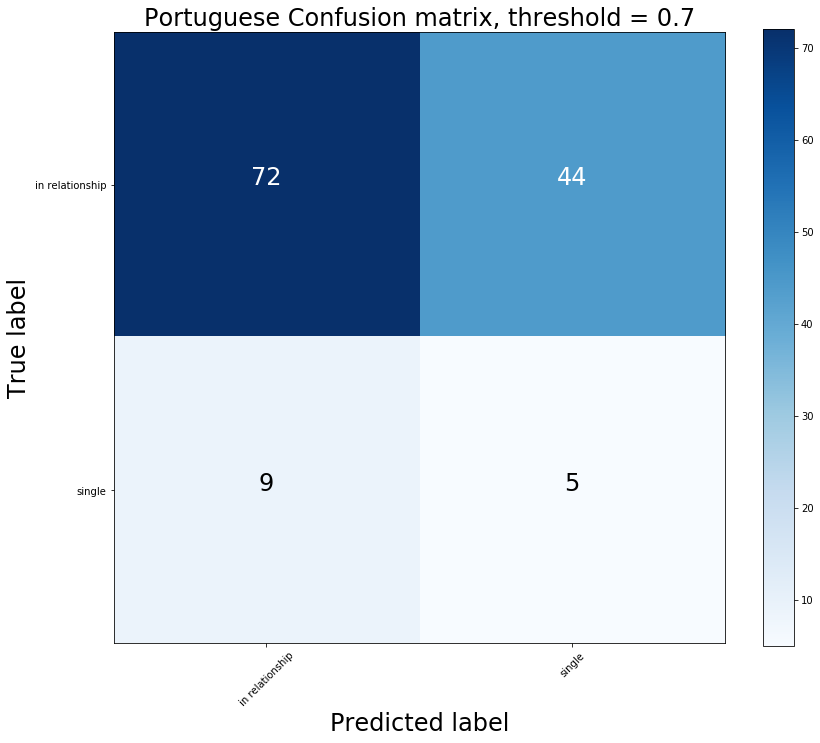

In [229]:
cnf_matrix = confusion_matrix(p_pred2, y_test_p.values)
np.set_printoptions(precision=2)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
ax.grid(False)
class_names = ["in relationship","single"]
plot_confusion_matrix(cnf_matrix, ax, classes=class_names,normalize=False,
                      title='Portuguese Confusion matrix, threshold = 0.7')

In [ ]:
clf = LogisticRegression(cv=RepeatedStratifiedKFold(), penalty='l2', scoring='accuracy', class_weight='balanced', random_state=0)

m_model = clf.fit(X_m, y_m)
#p_model = clf.fit(X_p, y_p)

#m_clf.predict(X_m)

# set threshold...
m_thresh = 0.7 

m_probs = m_model.predict_proba(X_m)

m_labels = np.where(m_probs >= m_thresh, 1, 0)

acc_m = m_model.score(X_m, y_m)

print("Accuracy: {}".format(acc_m))


In [69]:
tpr, fpr, thresholds = roc_curve(y_m, m_probs)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot of loan data")
plt.show()

ValueError: bad input shape (316, 2)